## Pytorch VS Pytorch Lightning

The following tutorial aims to show the difference between Pytorch and Pytorch Lightning, comparing what lightning does under the hood to simplify the training process. The Notebook contains following sections: 

- Generate Data 
- Native Pytorch implementation 
- Pytorch Lightning training: Implement training in pytorch lightning 
---

In [24]:
import lightning
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from typing import List
from sklearn.model_selection import train_test_split


## 🧪 Synthetic Polynomial Regression Dataset (PyTorch)

This synthetic dataset is generated using a **nonlinear polynomial function** with two input features (`x1`, `x2`) and a scalar target `y`. It is ideal for demonstrating regression model training, overfitting behavior, and nonlinear pattern learning using PyTorch or PyTorch Lightning.

---

### 📐 Data Generation Formula

The target variable `y` is generated using the following equation:

The equation for \(y\) is given by:
$$
y = 10x_{1}^{2} + 5x_{2}^{2} + 2x_{1}x_{2} + 3x_{1} + 4x_{2} + \varepsilon
$$

Where the variables are distributed as follows:
- \( x_{1} ) follows a continuous uniform distribution between -10 and 10, denoted as \(x_{1} \sim \mathcal{U}(-10, 10)\).
- \( x_{2} \) follows a continuous uniform distribution between 0 and 5, denoted as \(x_{2} \sim \mathcal{U}(0, 5)\).
- \( \varepsilon \) represents Gaussian noise with a mean of 0 and a variance of \(2^{2} = 4\), denoted as \( \varepsilon \sim \mathcal{N}(0, 2^{2}) \).

---

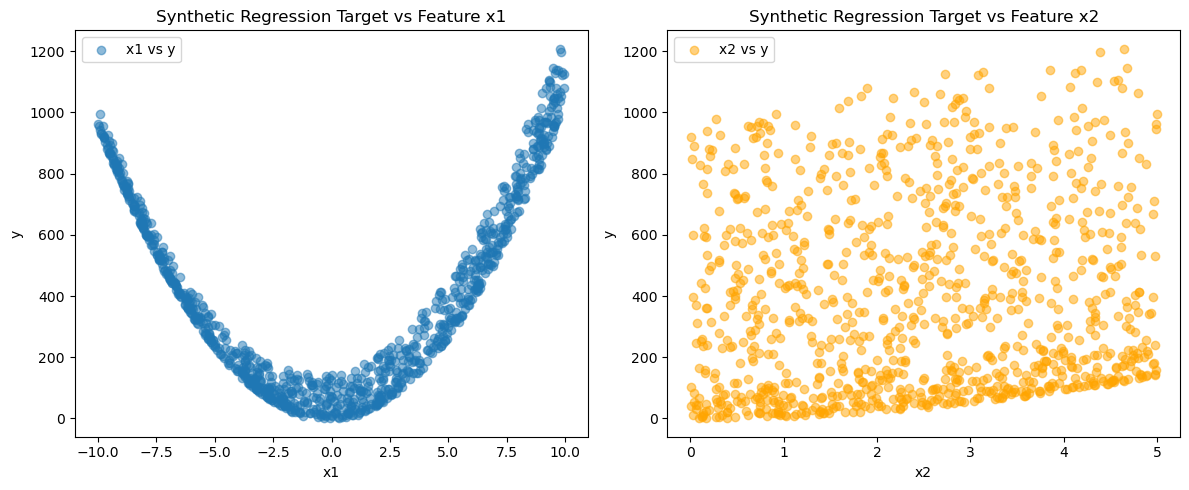

In [25]:
n_samples = 1000
# setting the global seed for pytorch 
torch.manual_seed(99)
# Setting a custom seed for the random number generator
generator = torch.Generator().manual_seed(99)
# Creating uniform random numbers for x1 and x2
x1 = torch.empty(n_samples, dtype=torch.float32).uniform_(-10,10,generator=generator)
x2 = torch.empty(n_samples, dtype = torch.float32).uniform_(0,5,generator=generator)

# Generating the noise 
noise = torch.normal(mean=0, std=2, size=(n_samples,), generator=generator)
# Creating the target variable polynomial 
y = 10 * x1**2 + 5 * x2**2 + 2 * x1 * x2 + 3*x1 + 4*x2 +noise
# vertical stacking to create the input traning data  
X = torch.stack([x1, x2], dim=1)
# creating the target 
y = y.view(-1, 1)
# Plotting data (moved before the split for clarity)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0].numpy(), y.numpy(), alpha=0.5, label="x1 vs y")
plt.xlabel("x1")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic Regression Target vs Feature x1")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 1].numpy(), y.numpy(), alpha=0.5, label="x2 vs y", color='orange')
plt.xlabel("x2")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic Regression Target vs Feature x2")
plt.tight_layout()
plt.show()


---
## Native Pytorch implementation 



In this section, we will implement the training process in Native Pytorch. The training process includes the following steps 

- Define the model 
- Initialize the loss function for the use case
- Select an Optimizer to for learning the paramters 
- Define the scheduler 
- Initialize the dataloaders 
- Design the training loop 


In [26]:
# define the model 

class PolynomialRegressionNNForwardActivation(nn.Module):
    """
    A PyTorch Multi-Layer Perceptron (MLP) model for polynomial regression
    with activation functions defined in the forward method.

    This model takes a single input feature and predicts a single output
    by learning a non-linear mapping through user-defined hidden layers.
    It can approximate polynomial relationships of varying degrees.
    """
    def __init__(self, input_size:int=1, hidden_layers:List[int]=[10], output_size : int=1):
        """
        Initializes the PolynomialRegressionNNForwardActivation model.

        Args:
            input_size (int): The number of input features (typically 1 for simple
                              polynomial regression). Defaults to 1.
            hidden_layers (list of int): A list defining the number of neurons
                                         in each hidden layer. For example,
                                         `[10, 20, 15]` would create three hidden
                                         layers with 10, 20, and 15 neurons, respectively.
                                         Defaults to `[10]` (one hidden layer with 10 neurons).
            output_size (int): The number of output features (typically 1 for
                               polynomial regression). Defaults to 1.
        """
        super(PolynomialRegressionNNForwardActivation, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers_config = hidden_layers
        self.linear_layers = nn.ModuleList()
        self.relu = nn.ReLU()

        # Input layer to first hidden layer
        self.linear_layers.append(nn.Linear(self.input_size, self.hidden_layers_config[0]))

        # Hidden layers
        for i in range(len(self.hidden_layers_config) - 1):
            self.linear_layers.append(nn.Linear(self.hidden_layers_config[i], self.hidden_layers_config[i+1]))

        # Output layer
        if self.hidden_layers_config:
            self.linear_layers.append(nn.Linear(self.hidden_layers_config[-1], self.output_size))
        else:
            self.linear_layers.append(nn.Linear(self.input_size, self.output_size)) # No hidden layers

    def forward(self, x:torch.Tensor):
        """
        Performs the forward pass of the polynomial regression MLP
        with activation functions applied directly in this method.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_size).
        """
        x = self.linear_layers[0](x)
        x = self.relu(x)

        for i in range(1, len(self.linear_layers) - 1):
            x = self.linear_layers[i](x)
            x = self.relu(x)

        # Output layer (no activation typically for regression)
        x = self.linear_layers[-1](x)
        return x

In [55]:
# intialize the model
model = PolynomialRegressionNNForwardActivation(input_size=2, hidden_layers=[10,20,10], output_size=1)

# Print the model parameters
print(model)
print('*'*10)

# intialize the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# set the batch size
batch_size = 32
# train test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# define the dataloader 

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


PolynomialRegressionNNForwardActivation(
  (linear_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
  (relu): ReLU()
)
**********


In [56]:
# set the number of epochs
n_epochs = 200

# set the loss history
loss_history = []

# implement the training loop
for epoch in range(n_epochs):
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        y_pred = model(batch_X)
        # Compute the loss
        loss = loss_fn(y_pred, batch_y)
        # Backward pass and optimization
        # Zero the gradients
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update the weights
        optimizer.step()
    # Step the scheduler
    scheduler.step()
    # Store the loss
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 6656.0215
Epoch [20/200], Loss: 1754.6571
Epoch [30/200], Loss: 511.5524
Epoch [40/200], Loss: 166.2451
Epoch [50/200], Loss: 111.2583
Epoch [60/200], Loss: 66.6002
Epoch [70/200], Loss: 45.5403
Epoch [80/200], Loss: 73.0542
Epoch [90/200], Loss: 68.8322
Epoch [100/200], Loss: 63.5256
Epoch [110/200], Loss: 37.4702
Epoch [120/200], Loss: 22.0504
Epoch [130/200], Loss: 42.6953
Epoch [140/200], Loss: 38.7450
Epoch [150/200], Loss: 27.9323
Epoch [160/200], Loss: 44.0117
Epoch [170/200], Loss: 62.1233
Epoch [180/200], Loss: 29.7455
Epoch [190/200], Loss: 19.2304
Epoch [200/200], Loss: 44.3804


Test Loss: 44.4919


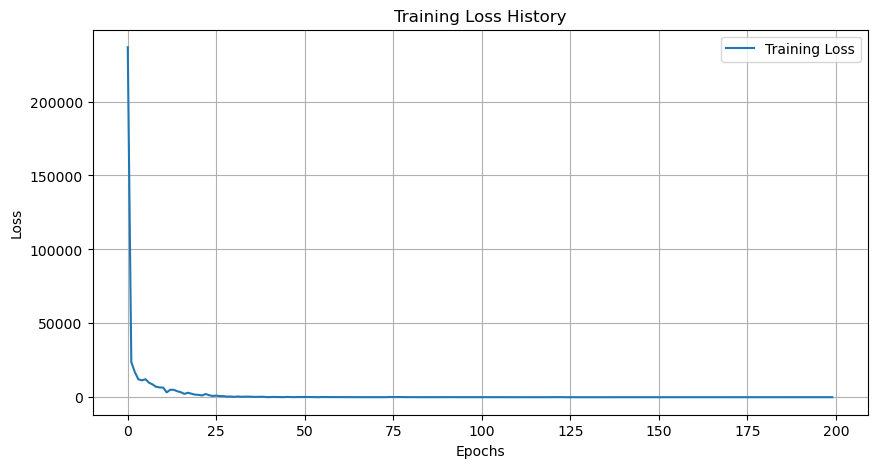

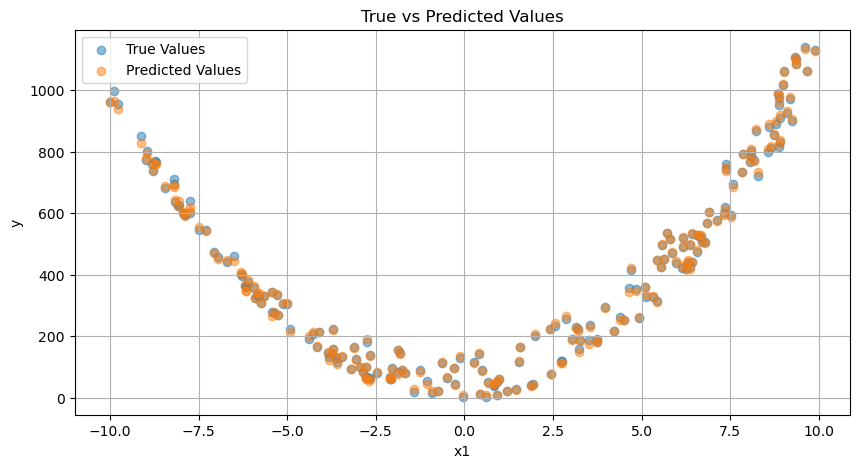

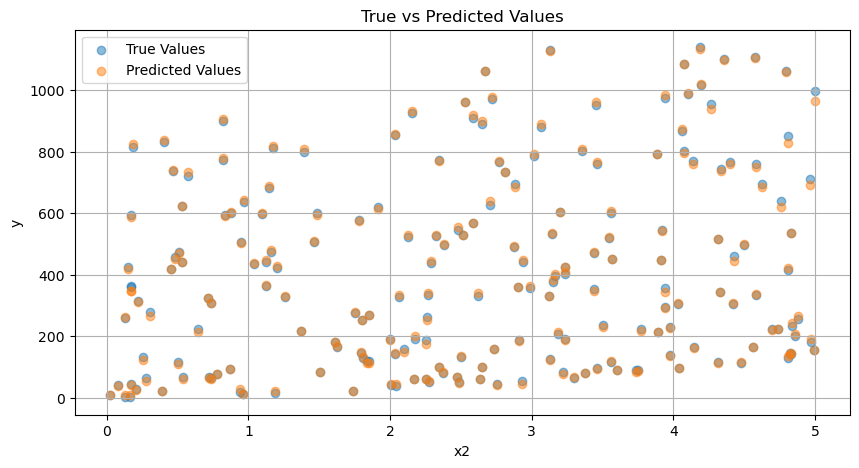

In [57]:
# compute the test loss
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
# plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid()
plt.show()
# plot the predictions
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 0].numpy(), y_test.numpy(), label='True Values', alpha=0.5)
plt.scatter(X_test[:, 0].numpy(), y_test_pred.numpy(), label='Predicted Values', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('y')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid()
plt.show()
# plot the predictions
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 1].numpy(), y_test.numpy(), label='True Values', alpha=0.5)
plt.scatter(X_test[:, 1].numpy(), y_test_pred.numpy(), label='Predicted Values', alpha=0.5)
plt.xlabel('x2')
plt.ylabel('y')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid()
plt.show()
